In [1]:
using Random
using CairoMakie
using JLD2
using Printf
using StatsBase
include("../AnalysisUtils.jl")

function euler_maruyama_K!(
    K::Vector{Float64},
    b::Float64,
    Δt::Float64,
    nsteps::Int;
    rng = Random.default_rng()
)
    N = length(K)
    ξ = zeros(N)
    K_hist = zeros(N, nsteps)
    K_hist[:,1] .= K

    for n in 2:nsteps
        randn!(rng, ξ)
        @views K_hist[:,n] = K_hist[:,n-1] .* (1 .+ 3b * Δt .+ sqrt(2b) * sqrt(Δt) * ξ)
    end

    return K_hist
end

N = 10_000
K0 = 10.0
b  = 1e-2
Δt = 0.1
nsteps = 1000

K = fill(K0, N);

#K_hist = euler_maruyama_K!(K, b, Δt, nsteps);

In [47]:
#run_directory = "/scratch/nad9961/swqg_rays/1318240"
#run_directory = "/scratch/nad9961/twolayer_rays/1390217"
#run_directory = "/scratch/nad9961/twolayer_rays/1363049"
#run_directory = "/scratch/nad9961/twolayer_rays/1523230/1"
#run_directory = "/scratch/nad9961/twolayer_rays/1542998/10" # Only 8,9,10 are good
#run_directory = "/scratch/nad9961/twolayer_rays/1545877/8"
run_directory = "/scratch/nad9961/twolayer_rays/1554309/4"

t0, x, k, u = load_snapshot(run_directory, 2)
Nsnapshots = count_snapshots(run_directory)
Npackets = size(x, 1)
println(Npackets)
frames = 2:10:Nsnapshots
K_hist = zeros(size(u,1), length(frames))
u_hist = zeros(size(u,1), 2, length(frames))
x_hist = zeros(size(u,1), 2, length(frames))
ts = zeros(length(frames))
idx = 1
for i=frames
    t, x, k, u = load_snapshot(run_directory, i)
    ts[idx] = t - t0
    K_hist[:,idx] = sqrt.(k[:,1].^2 + k[:,2].^2)
    u_hist[:,:,idx] .= u
    x_hist[:,:,idx] .= mod.(x .+ π, 2π) .- π
    idx += 1
end

147456


In [48]:
1+1

2

In [49]:
rms_u = sqrt.(sum(u_hist[:,1,:].^2 + u_hist[:,2,:].^2, dims=1) / Npackets)

1×779 Matrix{Float64}:
 0.0428472  0.0447922  0.0462259  …  0.0372281  0.0401072  0.0411709

In [50]:
K0 = 2
Nframes = length(frames)
println(Nframes)
vars = zeros(Nframes)
μs = zeros(Nframes)
for i=1:Nframes
    μs[i] = mean(K_hist[:,i])
    vars[i] = var(K_hist[:,i])
end

drift = (log.(μs/K0)./(ts))
diffusion = (log.(vars/K0^2 .* exp.(-2*drift.*ts) .+ 1) ./ (ts))

drift = drift[2:end]
diffusion = diffusion[2:end]

println("rms u: ", rms_u[end])
println("b: ", drift[end]/3)

779
rms u: 0.041170875350711685
b: 1.3977769435025165e-5


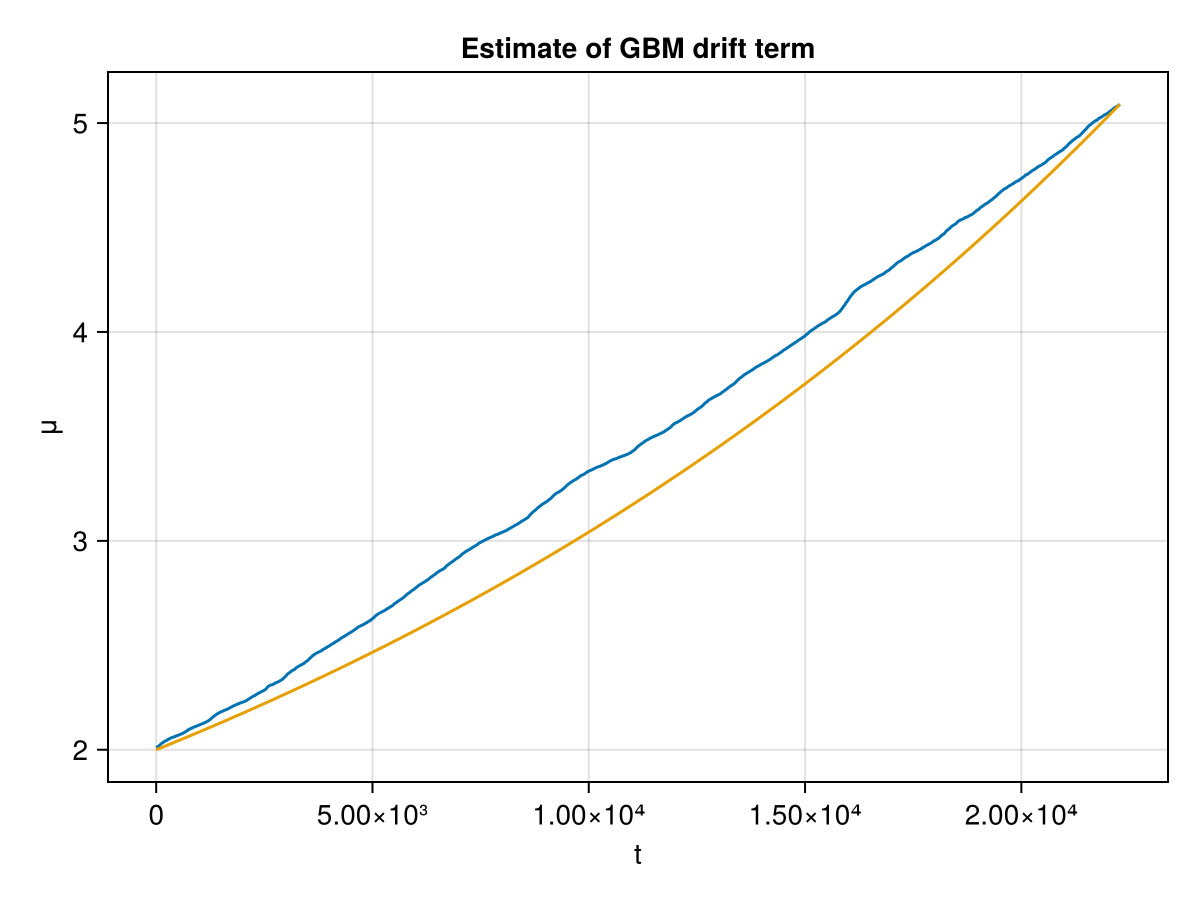

In [51]:
f = Figure()
ax = Axis(f[1,1], xlabel="t", ylabel="μ", title="Estimate of GBM drift term")


lines!(ax, ts, μs)
lines!(ax, ts, K0 * exp.(drift[end] .* ts))
#lines!(ax, ts[  


f

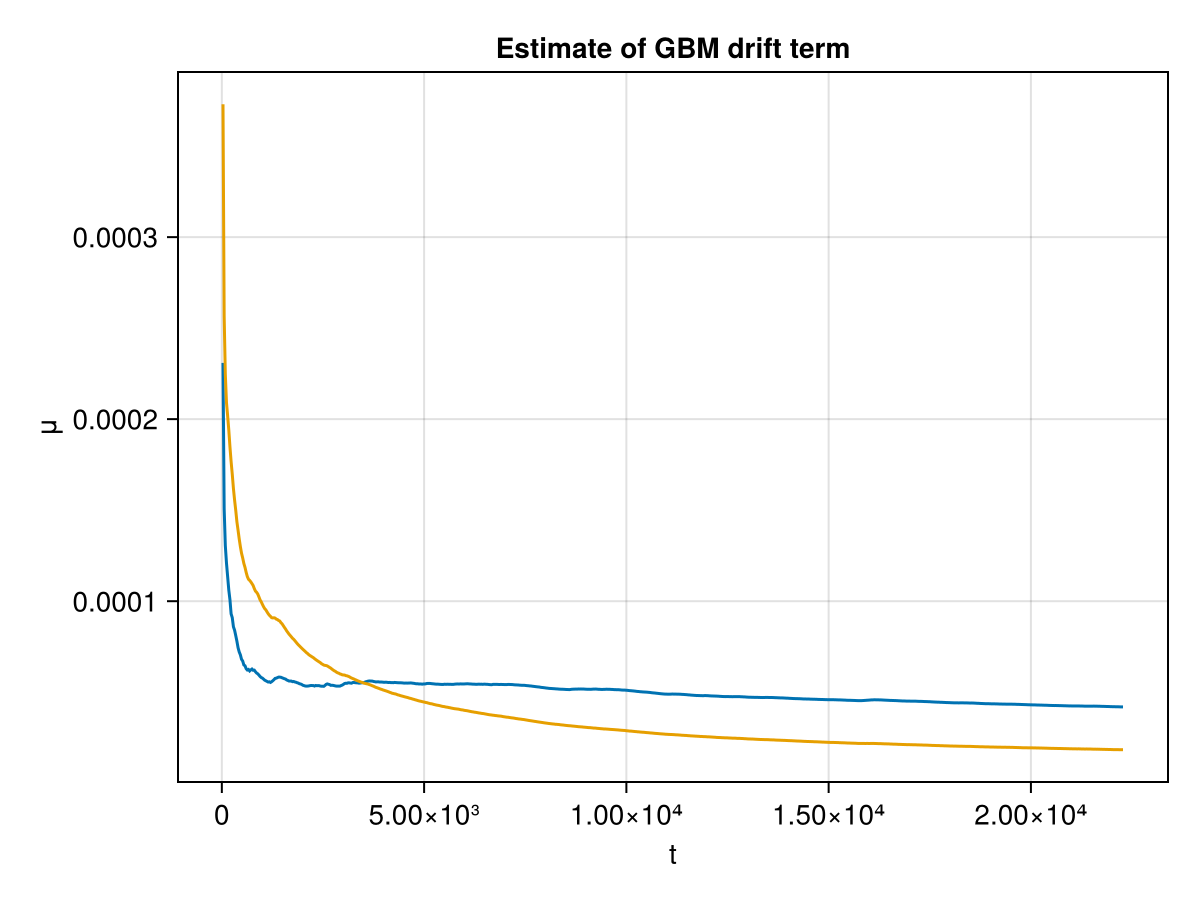

In [57]:
f = Figure()
ax = Axis(f[1,1], xlabel="t", ylabel="μ", title="Estimate of GBM drift term")


#lines!(ax, ts, μs)
lines!(ax, ts[2:end], drift)
lines!(ax, ts[2:end], diffusion)
#lines!(ax, ts[  


f

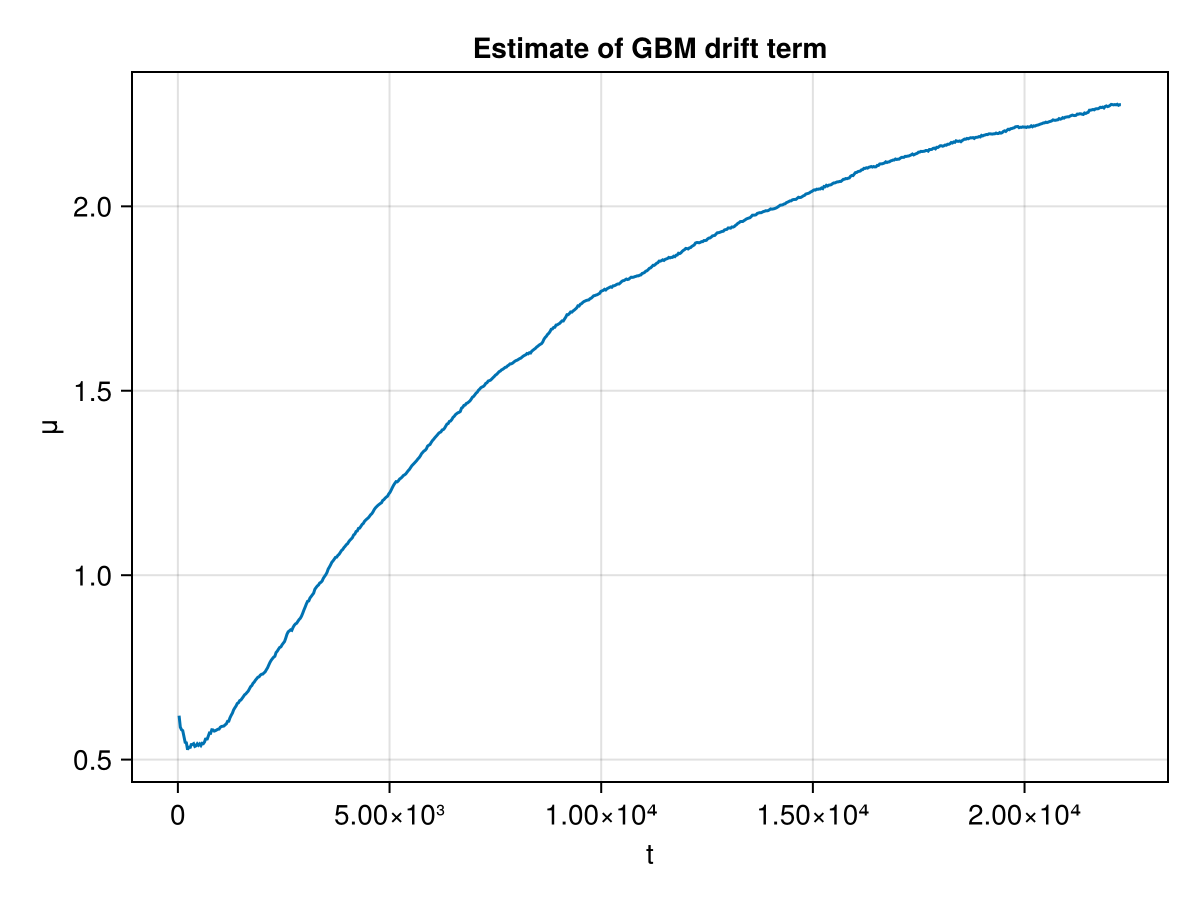

In [58]:
f = Figure()
ax = Axis(f[1,1], xlabel="t", ylabel="μ", title="Estimate of GBM drift term")


#lines!(ax, ts, μs)
lines!(ax, ts[2:end], drift ./ diffusion)
#lines!(ax, ts[2:end], diffusion)
#lines!(ax, ts[  


f

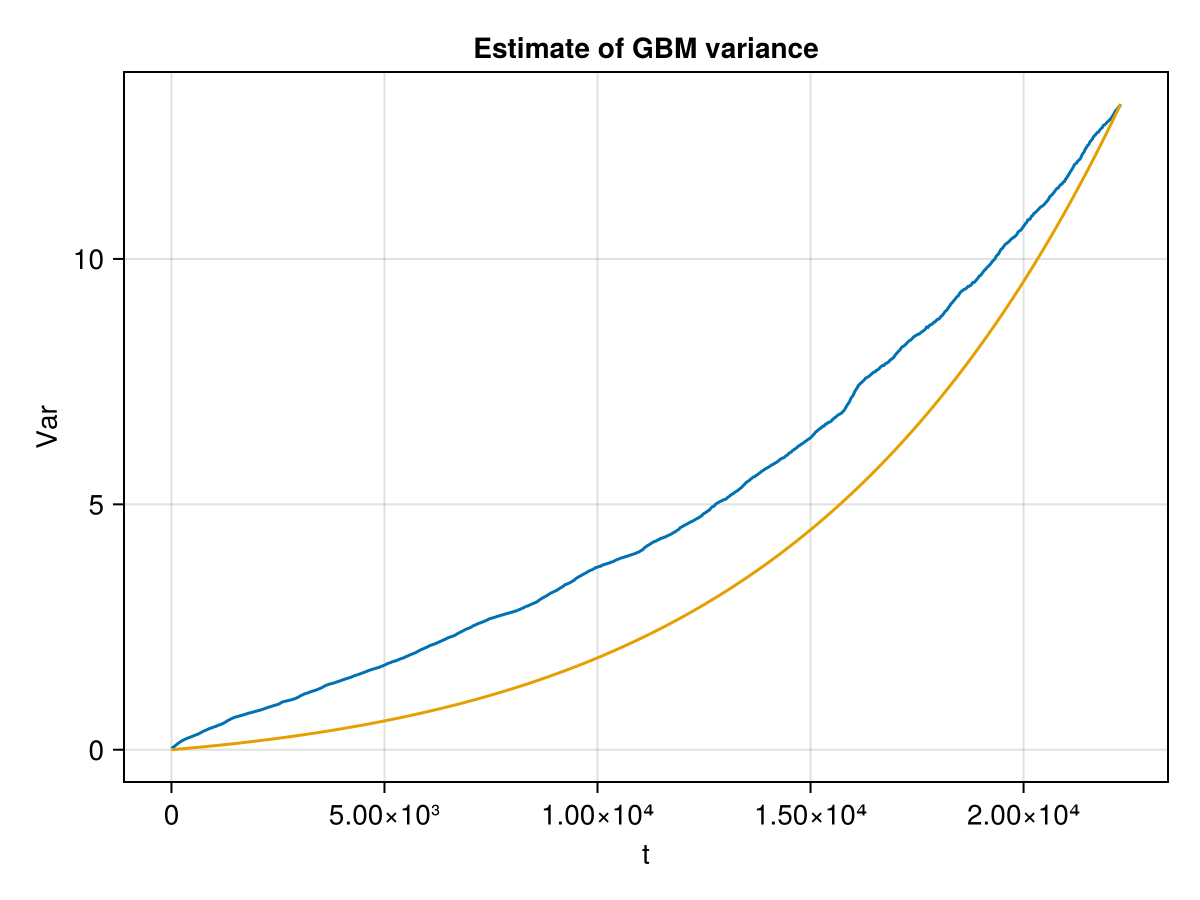

In [52]:
f = Figure()
ax = Axis(f[1,1], xlabel="t", ylabel="Var", title="Estimate of GBM variance")

lines!(ax, ts, vars)
lines!(ax, ts, K0^2 * exp.(2*drift[end]*ts) .* (exp.(diffusion[end] * ts) .- 1))
#lines!(ax, ts[
f

In [140]:
m_diff = mean(diffusion)
m_drift = mean(drift)
println(m_drift/3)
println(m_diff/2)

1.5447988944030643e-5
2.00695979620768e-5


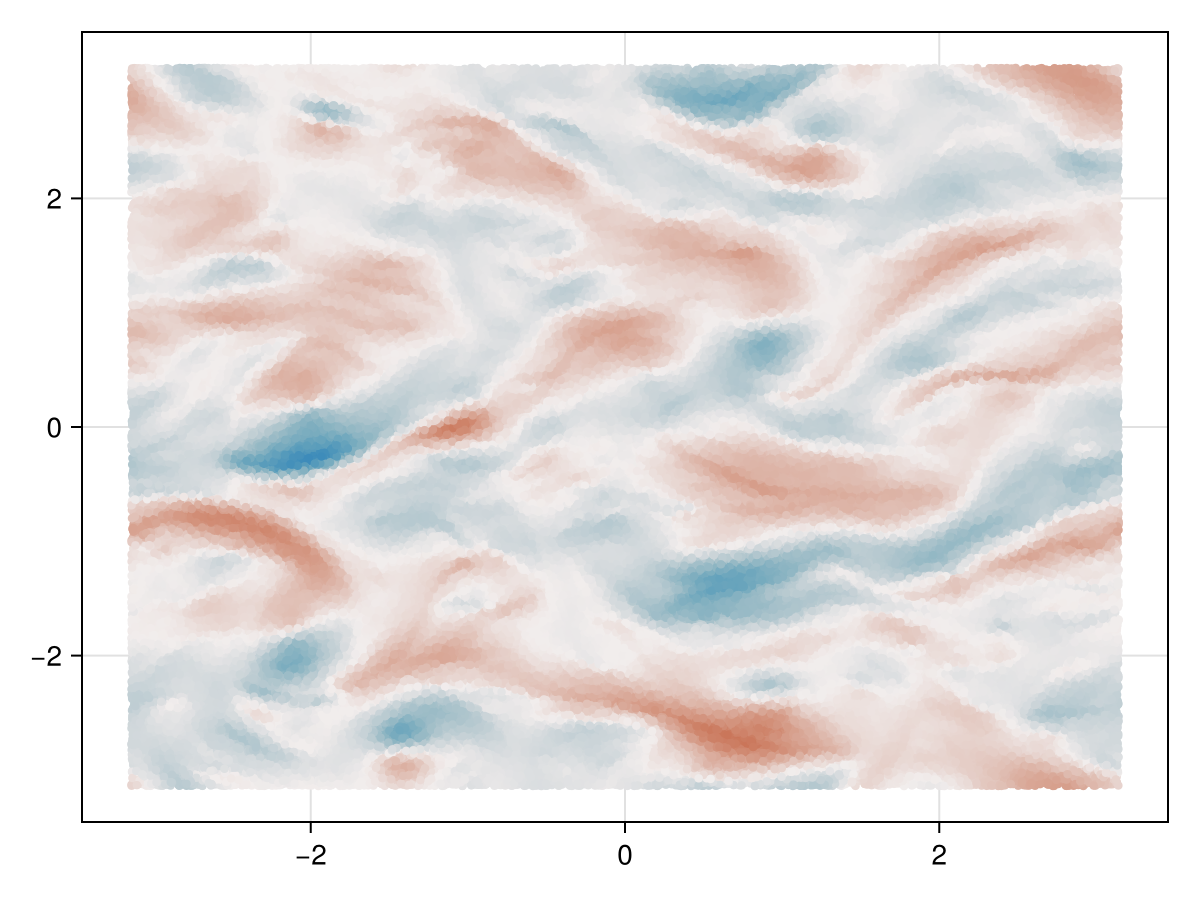

In [141]:
idx = 4
u_max = maximum(abs.(u_hist))
scatter(x_hist[:,1,idx], x_hist[:,2,idx], markersize=6, color=u_hist[:,1,idx], colormap=:balance, colorrange=(-u_max, u_max))

In [80]:
idx = 77
sqrt.(sum(u_hist[:,1,idx].^2 + u_hist[:,2,idx].^2) / size(u_hist, 1))

4.456411493172676e-5

In [81]:
size(u_hist)

(147456, 2, 164)

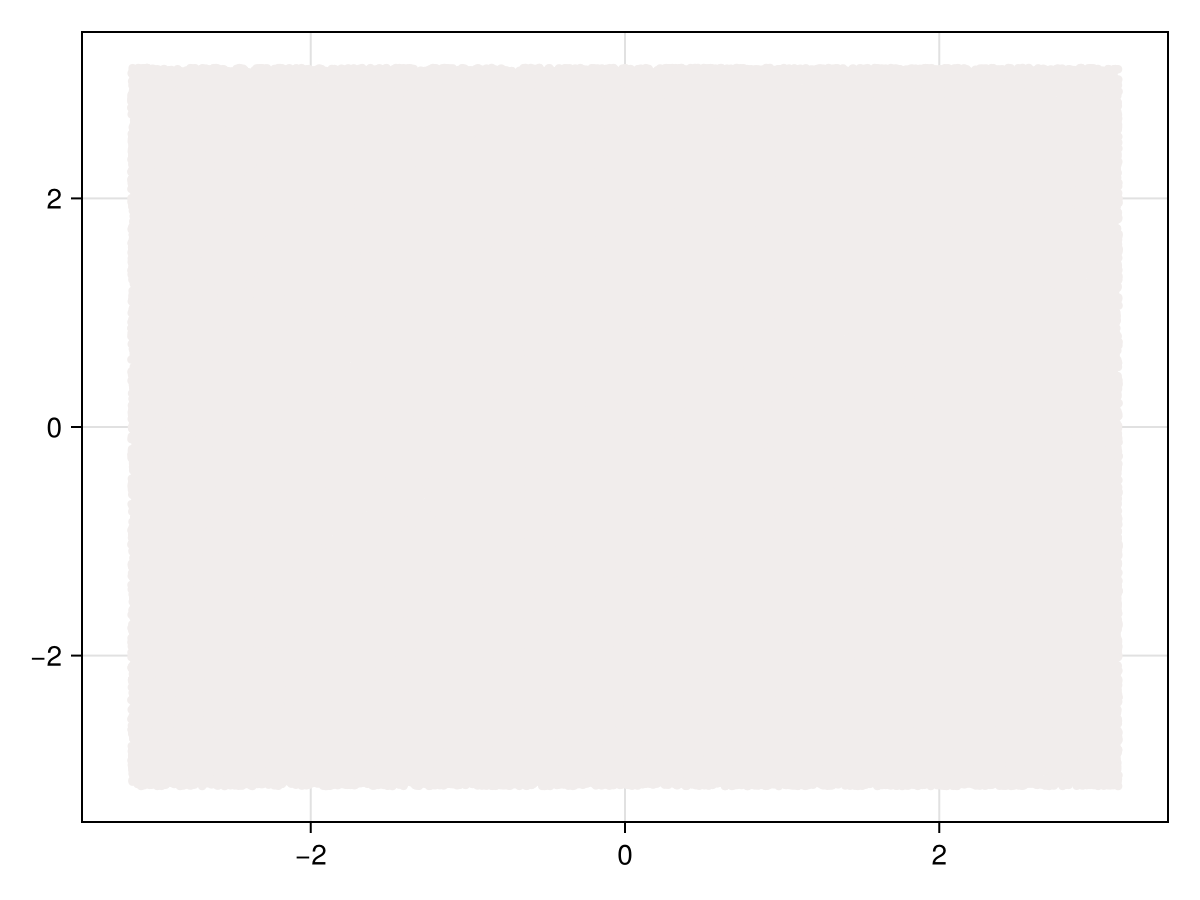

In [82]:
idx = 30
scatter(x_hist[:,1,idx], x_hist[:,2,idx], markersize=6, color=u_hist[:,1,idx], colormap=:balance, colorrange=(-0.3, 0.3))

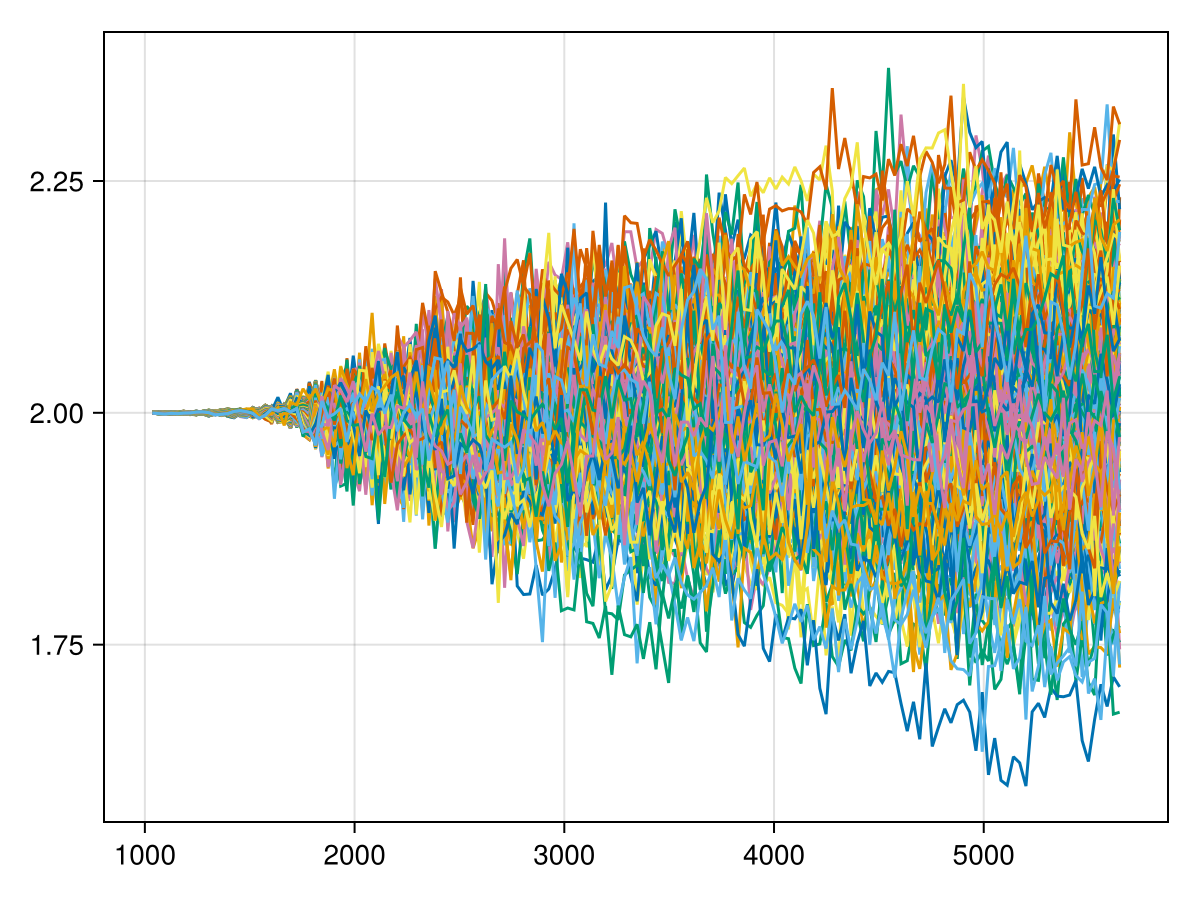

In [70]:
f = Figure()
ax = Axis(f[1,1])
for i=200:2:600
    lines!(ax, ts[2:end], K_hist[i,2:end])
end

f

In [71]:
maximum(K_hist)

2.6723783799822067

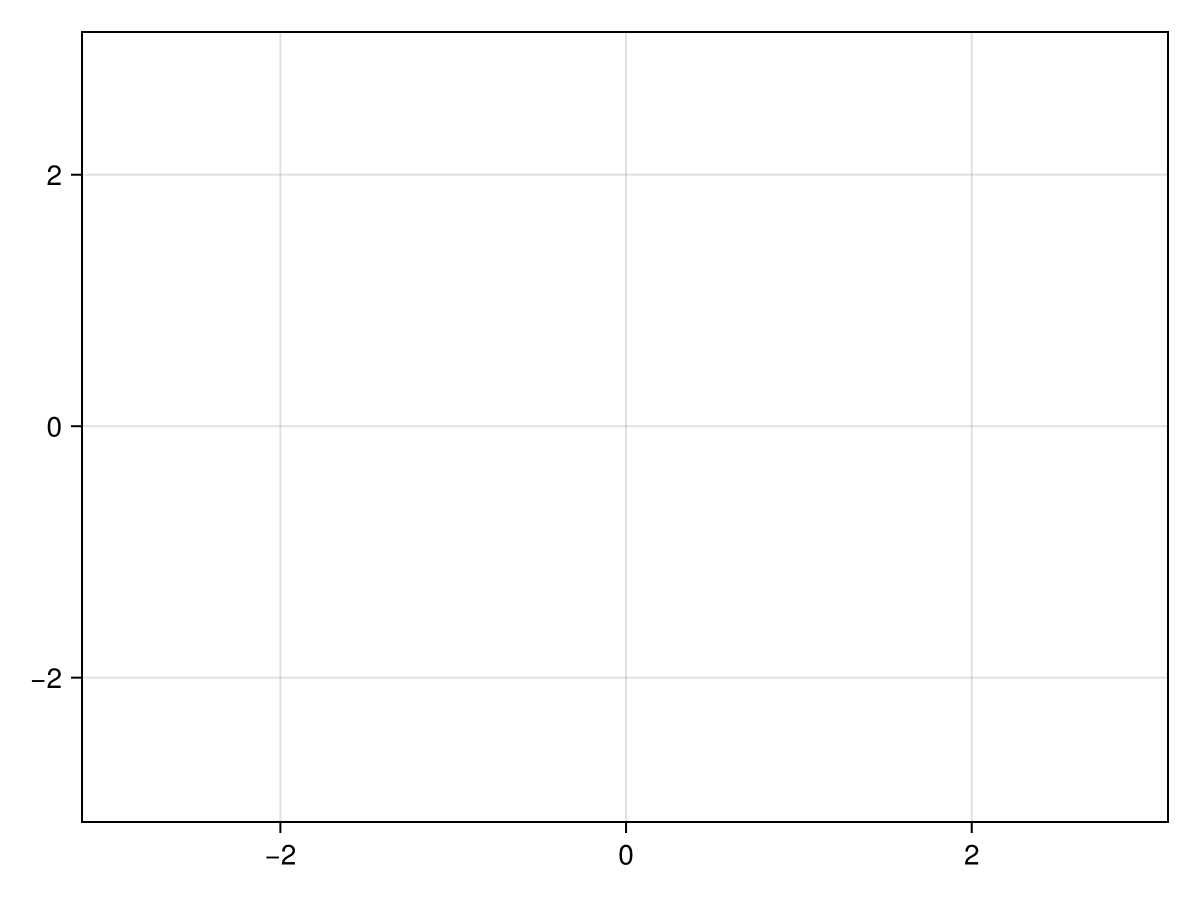

In [147]:
run_directory = "/scratch/nad9961/twolayer_rays/1545877/10"
grid = TwoDGrid(; nx=512, Lx=2π)
Nqg_snapshots = count_key_snapshots(run_directory, "2Lqg")
t, qh = load_key_snapshot(run_directory, "2Lqg", Nqg_snapshots)
q = irfft(qh, grid.nx)

heatmap(grid.x, grid.y, q[:,:,1] - q[:,:,2], colormap=:balance)

In [26]:
using FourierFlows

#run_directory = "/scratch/nad9961/twolayer_rays/1542998/10"
run_directory = "/scratch/nad9961/twolayer_rays/1554309/6"
diag_file = jldopen(@sprintf("%s/diagnostics.jld2", run_directory))
t = diag_file["diagnostics/kinetic_energy/t"]
KE = diag_file["diagnostics/kinetic_energy/data"]
close(diag_file)

Nqg_snapshots = count_key_snapshots(run_directory, "2Lqg")
_, qh = load_key_snapshot(run_directory, "2Lqg", Nqg_snapshots)
params = read_2Lqg_params(run_directory, "2Lqg")

grid = TwoDGrid(; nx=512, Lx=2π)
qch = 0.5 * (qh[:,:,1] - qh[:,:,2])
ψch = -qch ./ (grid.Krsq .+ 2*params.F)
uch = -1im * grid.l  .* ψch
vch =  1im * grid.kr .* ψch

uc = irfft(uch, grid.nx)
vc = irfft(vch, grid.nx)

u_rms = sqrt.(sum(uc.^2 + vc.^2)/grid.nx/grid.ny)

KE1 = first.(KE)
KE2 = first.(Base.rest.(KE, 2));

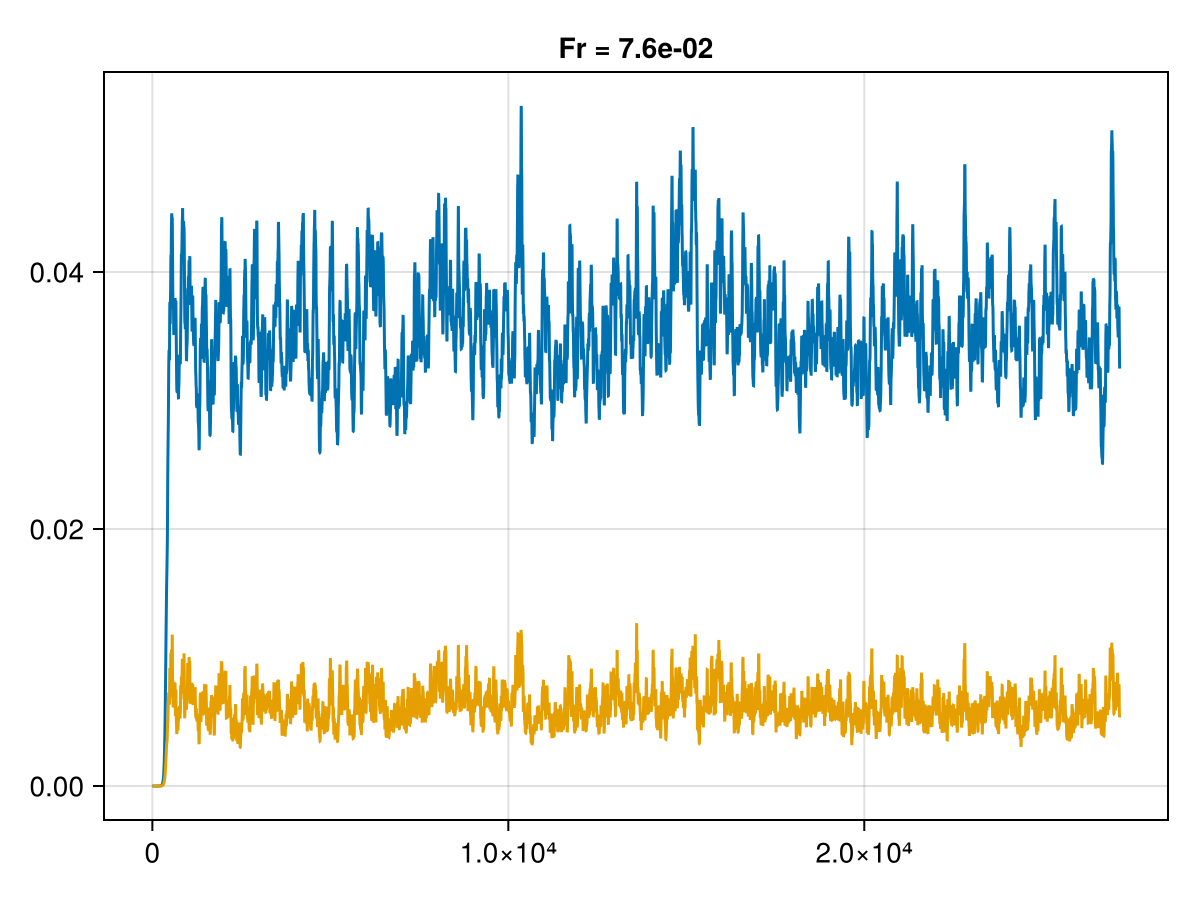

In [27]:
f = Figure()
ax = Axis(f[1,1], title=@sprintf("Fr = %0.1e",u_rms))

lines!(t, KE1)
lines!(t, KE2)

f